In [7]:
from pyomo.core import *
from pyomo.opt import SolverFactory, SolverManagerFactory
import pyomo.environ
import pandas as pd
import numpy as np
from itertools import compress
import seaborn as sns
#import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from operator import add
import scipy.io as sio

In [8]:
%matplotlib inline #show plots in jupyter notebook and not in a new window

In [9]:
from IPython.core.display import HTML
HTML("<style>.container { width:80% !important; }</style>")

# Input data class

In [21]:
class InputData:
    
    #-----------------------------------------------------------------------
    #  Initialization when class is created
    #-----------------------------------------------------------------------
    
    def __init__(self, ExcelPath, demands='Demand data',solar='Solar data', tech='Technology', gen='General'):  #if no values are passed, use default ones
        self.path = ExcelPath
        self.DemandSheet = demands
        self.SolarSheet = solar
        self.TechSheet = tech
        self.GeneralSheet = gen
        
        self.TechOutputs = None
        self.Technologies = None
        self.DemandData = None
        self.StorageData = None
        self.numberofhubs = None
        self.numberofdemands = None
        
        self.Initialize() #call variable intialization function
        
    def Initialize(self):
        """ 
        Initialize paramaters
        """
        self.Hubs()
        self.Demanddata()
        self.TechParameters()
        self.TechOutput()
        self.Storage()        
        
    def TechParameters(self):
        """
        Load from excel technologies and their parameters.
        Skip all other lines on the sheet that are not related to the technologies.
        """
        Technologies=pd.read_excel(self.path,sheetname=self.TechSheet, skiprows=1, index_col=0, skip_footer=38) #technology characteristics
        Technologies=Technologies.dropna(axis=1, how='all') #technology characteristics 
        Technologies=Technologies.fillna(0) #technology characteristics
        dd={}
        for i in range(self.numberofhubs):
            dd[i]=Technologies
        self.Technologies=pd.Panel(dd) #each hub has it's own technology dataframe
    
    def TechOutput(self):
        """
        Load from excel output of technologies.
        Skip all other lines on the sheet that are not related to the technologies output.
        """
        TechOutputs=pd.read_excel(self.path,sheetname=self.TechSheet, skiprows=15, index_col=0, skip_footer=28) #Output matrix
        TechOutputs=TechOutputs.dropna(axis=0,how='all')  #Output matrix
        TechOutputs=TechOutputs.dropna(axis=1,how='all')  #Output matrix
        self.TechOutputs=TechOutputs
        
    def Demanddata(self):
        """
        Load from excel demand data.
        """
        DemandDatas=pd.read_excel(self.path,sheetname=self.DemandSheet, header=None, skiprows=0)
        self.numberofdemands = DemandDatas[1][0]
        dd={}
        for i in range(self.numberofhubs):
            dd[i] = DemandDatas.loc[3:,(i+1)*self.numberofdemands-(self.numberofdemands-1):(i+1)*self.numberofdemands] #every i-th is new hub and every hub is a new dataframe
        self.DemandData=pd.Panel(dd)
        
    def Storage(self):
        """
        Load from excel storage data.
        Skip all other lines on the sheet that are not related to the storage.
        """
        Storage=pd.read_excel(self.path,sheetname=self.TechSheet, skiprows=40, index_col=0, skip_footer=0, header = 0) #
        Storage=Storage.dropna(axis=1, how='all')
        Storage=Storage.fillna(0)
        self.StorageData=Storage
        
    def Hubs(self):
        """
        Get number of hubs/nodes from the excel.
        """    
        number=pd.read_excel(self.path,sheetname=self.GeneralSheet, skiprows=17, index_col=0, skip_footer=0) #Output matrix
        number=number.dropna(axis=1,how='all')  #Output matrix
        number=number.iloc[0][0]
        self.numberofhubs=number
        
    
    
    
    #------------------------------------------------------------------------------------
    #  Functions used for translating dataframe/panels to dictionary format used by Pyomo
    #-----------------------------------------------------------------------------------

    def Dict1D(self,dictVar,dataframe):
        """
        When the key in Pyomo dict is 1-D and it's equal to the order of data.
        """
        for i,vali in enumerate(dataframe.index):
            dictVar[i+1]=round(dataframe.iloc[i][1],4)
        return dictVar

    def Dict1D_val_index(self,dictVar,dataframe):
        """
        When the key in Pyomo dict is 1-D and it's equal to the value of dataframe index name.
        """
        for i,vali in enumerate(dataframe.index):
            dictVar[vali]=round(dataframe.iloc[i][1],4)
        return dictVar

    def DictND(self,dictVar,dataframe):
        """
        When the key in Pyomo dict is 2-D and it's equal to the value of dataframe index/column name.
        """
        for i,vali in enumerate(dataframe.index):
            for j,valj in enumerate(dataframe.columns):
                dictVar[vali,valj]=dataframe.loc[vali][valj]
        return dictVar
    
    def DictPanel(self, dictVar,panel):
        """
        When the key in Pyomo dict is 3-D+ and it's equal to the order of data.
        """
        for x,valx in enumerate(panel.items):
            for i, vali in enumerate(panel[valx].dropna(axis=0, how ='all').index):
                for j, valj in enumerate(panel[valx].dropna(axis=1, how ='all').columns):
                    dictVar[x+1,j+1, i+1] = panel[valx].loc[vali][valj] #Pyomo starts from 1 and Python from 0
        return dictVar
    
    
    #----------------------------------------------------------------------
    # Load profiles
    #----------------------------------------------------------------------
    
    def Demands(self):
        """
        Return Pyomo formatted demand data for all hubs.
        """    
        dummy={}
        for i in range(self.DemandData.shape[0]):
            dummy[i]=self.DemandData[i].transpose()
        
        Demand=pd.Panel(dummy)
        loads_init={}
        loads_init=self.DictPanel(loads_init,Demand)
        return loads_init
    
    
    
    
    #----------------------------------------------------------------------
    # Irradiation
    #----------------------------------------------------------------------
    
    def SolarData(self):
        """
        Return Pyomo formatted solar data.
        """  
        SolarData=pd.read_excel(self.path,sheetname=self.SolarSheet)
        SolarData.columns=[1]
        solar_init={}
        solar_init=self.Dict1D(solar_init,SolarData)
        return solar_init
    
    
    
    
    #----------------------------------------------------------------------
    # Dispatch technologies
    #----------------------------------------------------------------------
    
    def CHP_list(self):
        """
        Return Pyomo formatted dispatch tech list for dispatch set.
        """  
        Dispatch_tech=pd.DataFrame(self.TechOutputs.sum(0)) #find dispatch tech (e.g. CHP)
        CHP_setlist=[]
        for n,val in enumerate(Dispatch_tech[0]):
            if val>1:
                CHP_setlist.append(n+2) #first is electricity, +1 since it starts at 0
        return CHP_setlist
    
    
    
    
    #----------------------------------------------------------------------
    # Roof technologies
    #----------------------------------------------------------------------
    
    def Roof_tech(self):
        """
        Return Pyomo formatted roof tech (e.g. PV, ST) for roof tech set.
        """  
        Roof_techset=[]
        for n,val in enumerate(self.Technologies[0].loc["Area (m2)"]): #take only 0th item since it is the same for all hubs
            if val>0:
                Roof_techset.append(n+2) #first is electricity +1 since it starts at 0
                
        return Roof_techset
    
    
    
    
    #----------------------------------------------------------------------
    # C-matrix
    #----------------------------------------------------------------------
        
    def cMatrix(self):
        """
        Return Pyomo formatted C-matrix data.
        """  
        
        #Based on the + - values, prepare data for generating coupling matrix        
        TechOutputs2=self.TechOutputs.multiply(np.array(self.Technologies[0].loc['Efficiency (%)']))
        TechOutputs2.loc[TechOutputs2.index!='Electricity']=TechOutputs2.loc[(TechOutputs2.index!='Electricity')].multiply(np.array(self.Technologies[0].loc['Output ratio'].fillna(value=1).replace(0,1))) #multiply all positive values of output matrix by COP/HER/efficiency
        TechOutputs2[TechOutputs2<0]=TechOutputs2[TechOutputs2<0].divide(np.array(self.Technologies[0].loc['Efficiency (%)'].fillna(value=1).replace(0,1))) #Get original value for negative values
        #TechOutputs2[TechOutputs2<0]=-1 #this is only needed if there is single input for e.g. HP

        addGrid=np.zeros(len(self.DemandData[0].dropna(axis=1, how ='all').columns),) #electricity is always present and added on the first place
        addGrid[0]=1 #add electricity to coupling matrix
        Grid=pd.DataFrame(addGrid,columns=["Grid"],index=self.DemandData[0].dropna(axis=1, how ='all').columns).transpose()
        
        Cmatrix=TechOutputs2.transpose()
        Cmatrix.columns = list(range(1,len(Cmatrix.columns)+1))
        Cmatrix=pd.concat([Grid,Cmatrix]) #combine grid with cmatrix containing only technologies
        Cmatrix.index=list(range(1,len(TechOutputs2.columns)+2)) #format column/row names for proper translation to Pyomo dict format
        Cmatrix.columns=list(range(1,len(TechOutputs2.index)+1)) #format column/row names for proper translation to Pyomo dict format
        cMatrixDict={}
        cMatrixDict=self.DictND(cMatrixDict,Cmatrix)
        
        return cMatrixDict
    
    
    
    
    #----------------------------------------------------------------------
    # Part load information
    #----------------------------------------------------------------------
    
    def PartLoad(self):
        """
        Return Pyomo formatted information about technologies' part load.
        """
        PartLoad=self.Technologies[0].loc["MinLoad (%)",]/100

        partload=self.TechOutputs.iloc[0:1].mul(list(PartLoad),axis=1)
        partload=pd.concat([partload,self.TechOutputs.iloc[1:].mul(list(PartLoad),axis=1)], axis=0)
        partload=partload.abs()
        partload=partload.transpose()
        partload.index=list(range(1+1,len(self.TechOutputs.columns)+2))
        partload.columns=list(range(1,len(self.TechOutputs.index)+1))
        SolartechsSets=list(compress(list(range(1+1,len(self.Technologies[0].columns)+2)), list(self.Technologies[0].loc["Area (m2)"]>0)))

        for i in SolartechsSets:
            partload.drop(i, inplace=True) #remove from the part load list roof tech

        PartloadInput={}
        PartloadInput=self.DictND(PartloadInput,partload)
        
        return PartloadInput
    
    
    
    
    #----------------------------------------------------------------------
    # Maximum capacities
    #----------------------------------------------------------------------
    
    def MaxCapacityALL(self):
        """
        Return Pyomo formatted max capacity that can be installed for all technologies present in specific hub for all hubs.
        """
        maxCap={}
        for n in range(self.numberofhubs):
            MaxCap=pd.DataFrame(self.Technologies[n].loc["Maximum Capacity",])
            MaxCap.index=list(range(2,len(self.Technologies[n].loc["MinLoad (%)",].index)+2))
            maxCap[n]= MaxCap

            SolartechsSets=list(compress(list(range(1+1,len(self.Technologies[n].columns)+2)), list(self.Technologies[n].loc["Area (m2)"]>0)))
            
            for x in SolartechsSets:
                maxCap[n].iloc[x-2] = list(self.Technologies[n].loc["Area (m2)"])[x-2]
            if self.numberofhubs>2:
                for k in maxCap[n].index:
                    if isinstance(self.Technologies[n].loc["Hubs"][k-2],float) or isinstance(self.Technologies[n].loc["Hubs"][k-2],int) or isinstance(self.Technologies[n].loc["Hubs"][k-2],long):#check if technology is present in one or more hubs, otherwise there is error
                        if int(n+1) != int(self.Technologies[n].loc["Hubs"][k-2]):#
                            maxCap[n].loc[k] = 0#if tech is not present in n-th hub installed cap has to be 0
                    else:
                        if str(n+1) not in [x.strip() for x in self.Technologies[n].loc["Hubs"][k-2].split(',')]:#split at comma
                            maxCap[n].loc[k] = 0 #if tech is not present in n-th hub installed cap has to be 0
                            
            elif self.numberofhubs==2: #check if technology is present in one or more hubs, otherwise there is error
                for k in maxCap[n].index:
                    if isinstance(self.Technologies[n].loc["Hubs"][k-2],float) or isinstance(self.Technologies[n].loc["Hubs"][k-2],int):
                        if int(n+1) != int(self.Technologies[n].loc["Hubs"][k-2]):
                            maxCap[n].loc[k] = 0 #if tech is not present in n-th hub installed cap has to be 0
        #format column/row name
        CapacitiesPanel=pd.Panel(maxCap) #create panel for dict
        
        Capacities = CapacitiesPanel.to_frame()
        Capacities.reset_index(inplace = True)
        Capacities.index = Capacities['major']
        del Capacities['major']
        del Capacities['minor']
        Capacities.columns = [int(x)+1 for x in Capacities.columns] #format column/row names for proper translation to Pyomo dict
        del Capacities.index.name
        Capacities = Capacities.transpose()
        
        maximalcapacities={}
        maximalcapacities = self.DictND(maximalcapacities, Capacities)
        return maximalcapacities
    
    def MaxCapacity(self):
        """
        Return Pyomo formatted max capacity that can be installed for non-roof technologies present in specific hub for all hubs.
        """
        maxCap={}
        for n in range(self.numberofhubs):
            MaxCap=pd.DataFrame(self.Technologies[n].loc["Maximum Capacity",])
            MaxCap.index=list(range(2,len(self.Technologies[n].loc["MinLoad (%)",].index)+2))
            maxCap[n]= MaxCap

            SolartechsSets=list(compress(list(range(1+1,len(self.Technologies[n].columns)+2)), list(self.Technologies[n].loc["Area (m2)"]>0)))
            maxCap[n] = maxCap[n].drop(SolartechsSets) #if it is roof tech, remove it from dict
            if self.numberofhubs>2:
                for k in maxCap[n].index:
                    if isinstance(self.Technologies[n].loc["Hubs"][k-2],float) or isinstance(self.Technologies[n].loc["Hubs"][k-2],int)or isinstance(self.Technologies[n].loc["Hubs"][k-2],long): #check if technology is present in one or more hubs, otherwise there is error
                        if int(n+1) != int(self.Technologies[n].loc["Hubs"][k-2]):#
                            maxCap[n].loc[k] = 0 #if tech is not present in n-th hub installed cap has to be 0
                    else:
                        if str(n+1) not in [x.strip() for x in self.Technologies[n].loc["Hubs"][k-2].split(',')]:#if>=elif
                            maxCap[n].loc[k] = 0 #if tech is not present in n-th hub installed cap has to be 0
            elif self.numberofhubs==2:
                for k in maxCap[n].index:
                    if isinstance(self.Technologies[n].loc["Hubs"][k-2],float): #check if technology is present in one or more hubs, otherwise there is error
                        if int(n+1) != int(self.Technologies[n].loc["Hubs"][k-2]):
                            maxCap[n].loc[k] = 0 #if tech is not present in n-th hub installed cap has to be 0
        #format column/row name                
        CapacitiesPanel=pd.Panel(maxCap)
        
        Capacities = CapacitiesPanel.to_frame() #create panel for dict
        Capacities.reset_index(inplace = True)
        Capacities.index = Capacities['major']
        del Capacities['major']
        del Capacities['minor']
        Capacities.columns = [int(x)+1 for x in Capacities.columns] #format column/row names for proper translation to Pyomo dict
        del Capacities.index.name
        Capacities = Capacities.transpose()
        
        maximalcapacities={}
        maximalcapacities = self.DictND(maximalcapacities, Capacities)
        return maximalcapacities
    
    
    
    #----------------------------------------------------------------------
    # Predefined network connections
    #----------------------------------------------------------------------
        
     
    def FixedNetworks(self):
        """
        Return Pyomo formatted pre-installed (fixed) network(s).
        """
        Network=pd.read_excel(self.path,sheetname="Network", index_col=0, header=None)
        Network = Network.rename_axis(None)
        if Network.empty!=True:
            dummy={}
            numberofhubs = self.DemandData.shape[0]
            for i in range(1,self.numberofdemands+1): #Python starts from 0, Pyomo from 1
                if isinstance(Network.loc["Demand"][1],float): #if network is only for one demand
                    if i == int(Network.loc["Demand"][1]): #if it is for the right demand where network is present
                        dummynetwork = np.zeros((numberofhubs,numberofhubs))
                        for j in range(1, len(Network.columns)+1):
                            dummynetwork[int(Network.loc["Node 2"][j]-1),int(Network.loc["Node 1"][j]-1)] = 1 #connection is present between nodes i and j
                            dummy[i-1] = pd.DataFrame(dummynetwork)

                    else:
                        dummy[i-1] = pd.DataFrame(np.zeros((numberofhubs,numberofhubs)))

                else: #if network is for multiple demands
                    if str(i) not in list(Network.loc["Demand"][1]):
                        dummy[i-1] = pd.DataFrame(np.zeros((numberofhubs,numberofhubs)))

                    else:
                        dummynetwork = np.zeros((numberofhubs,numberofhubs))
                        for j in range(1, len(Network.columns)+1):
                                dummynetwork[int(Network.loc["Node 2"][j]-1),int(Network.loc["Node 1"][j]-1)] = 1
                                dummy[i-1] = pd.DataFrame(dummynetwork)

            network = pd.Panel(dummy)
            network_init={}
            network_init=self.DictPanel(network_init,network)
            return network_init
    
    
    #----------------------------------------------------------------------
    # Pyomo sets
    #----------------------------------------------------------------------
    
    def SolarSet(self):
        """
        Return Pyomo formatted list for set containing only roof techs (e.g. PV, ST).
        """
        return list(compress(list(range(1+1,len(self.Technologies[0].columns)+2)), list(self.Technologies[0].loc["Area (m2)"]>0)))
    
    
    def DispTechsSet(self):
        """
        Return Pyomo formatted list for set containing dispatch techs (e.g. CHP).
        """
        return list(compress(list(range(1+1,len(self.Technologies[0].columns)+2)), list(self.Technologies[0].loc["Area (m2)"]==0)))

    
    def partloadtechs(self):
        """
        Return Pyomo formatted list for set used for enforcing part load.
        """
        
        PartLoad=self.Technologies[0].loc["MinLoad (%)",]/100

        partload=self.TechOutputs.iloc[0:1].mul(list(PartLoad),axis=1)
        partload=pd.concat([partload,self.TechOutputs.iloc[1:].mul(list(PartLoad),axis=1)], axis=0)
        partload=partload.abs()
        partload=partload.transpose()
        partload.index=list(range(1+1,len(self.TechOutputs.columns)+2))
        partload.columns=list(range(1,len(self.TechOutputs.index)+1))
        SolartechsSets=list(compress(list(range(1+1,len(self.Technologies[0].columns)+2)), list(self.Technologies[0].loc["Area (m2)"]>0)))

        for i in SolartechsSets:
            partload.drop(i, inplace=True)
            
        return list(partload.loc[partload.sum(axis=1)>0].index)
    
    
    #----------------------------------------------------------------------
    # Linear investment cost
    #----------------------------------------------------------------------
    
    def LinearCost(self):
        """
        Return Pyomo formatted linear investment costs for all technologies including electricity (which has to be included and is equal to 0).
        """
        dummy = {}
        for n in range(self.numberofhubs):
            LinearCost=self.Technologies[n].loc["CapCost (chf/kW)",]

            linCost=self.TechOutputs.iloc[0:1].mul(list(LinearCost),axis=1)
            linCost=pd.concat([linCost,self.TechOutputs.iloc[1:].mul(list(LinearCost),axis=1)], axis=0)

            linCost=linCost.transpose()
            for name in linCost.columns[1:]:
                linCost.loc[linCost["Electricity"] >1, name] = 0

            linCost.loc[linCost["Electricity"] <0, "Electricity"]=0
            linCost=linCost.abs()
            linCost.columns = self.DemandData[n].dropna(axis=1).columns

            addGrid=np.zeros(len(self.DemandData[0].dropna(axis=1).columns),)
            addGrid[0]=1 #add electricity to linear cost dict
            Grid=pd.DataFrame(addGrid,columns=["Grid"],index=self.DemandData[n].dropna(axis=1).columns).transpose()

            linCost=pd.concat([Grid,linCost])

            linCost.index=list(range(1,len(self.TechOutputs.columns)+2))
            linCost.columns=list(range(1,len(self.TechOutputs.index)+1))
            linCost.loc[1]=0
            
            dummy[n] = linCost.transpose()
        
        linCost = pd.Panel(dummy)
        linCapCosts={}
        linCapCosts=self.DictPanel(linCapCosts,linCost)
        
        return linCapCosts
     
    
    
    
    #----------------------------------------------------------------------
    # Find which is the primary input for capacity 
    #----------------------------------------------------------------------
    def DisDemands(self):
        """
        Find which two outputs CHP is producing and save it into matrix.
        """
        
        CHPlist=self.CHP_list()
        dispatch_demands=np.zeros((len(CHPlist), 2), dtype=int)

        for n,val in enumerate(CHPlist):
            counter=0
            for i, value in enumerate(np.array(self.TechOutputs[[val-2]],dtype=int)):
                if value[0]>0 and counter==0:
                    dispatch_demands[n,0]=i+1
                    counter=1
                if value[0]>0 and counter==1:
                    dispatch_demands[n,1]=i+1

        return dispatch_demands    
    
    
    
    #----------------------------------------------------------------------
    # Interest rate
    #----------------------------------------------------------------------
    
    def InterestRate(self):
        """
        Return interest rate by reading excel.
        """
        Interest_rate=pd.read_excel(self.path,sheetname=self.GeneralSheet, skiprows=8, index_col=0, skip_footer=7) #
        Interest_rate=Interest_rate.dropna(axis=1,how='all')
        Interest_rate_R=Interest_rate.loc["Interest Rate r"][0]
        return Interest_rate_R
    
    
    
    
    #----------------------------------------------------------------------
    # Assumed lifetime of technologies
    #----------------------------------------------------------------------
    
    def LifeTime(self):
        """
        Return Pyomo formatted lifetime in years per technology.
        """
        dummy = {}
        for n in range(self.numberofhubs):
            Life=pd.DataFrame(list(self.Technologies[0].loc["Lifetime (yr)"]))
            Life.columns=[1]
            Life.index=list(range(2,len(self.TechOutputs.columns)+2))
            dummy[n]=Life
            
        Life = pd.Panel(dummy)
        
        Life= Life.to_frame() #same for all hubs
        Life.reset_index(inplace = True)
        Life.index = Life['major']
        del Life['major']
        del Life['minor']
        Life.columns = [int(x)+1 for x in Life.columns]
        del Life.index.name
        Life = Life.transpose()

        lifeTimeTechs={}
        lifeTimeTechs=self.DictND(lifeTimeTechs, Life)
        return lifeTimeTechs
        
    
    
    
    #----------------------------------------------------------------------
    # NPV
    #----------------------------------------------------------------------
        
    def NPV(self):
        """
        Return Pyomo formatted NPV value.
        """
        Interest_rate_R=self.InterestRate()
        Life=pd.DataFrame(list(self.Technologies[0].loc["Lifetime (yr)"]))
        Life.columns=[1]
        Life.index=list(range(2,len(self.TechOutputs.columns)+2))
        
        NetPresentValue=1 / (((1 + Interest_rate_R) ** Life - 1) / (Interest_rate_R * ((1 + Interest_rate_R) ** Life)))
        NetPresentValueTech={}
        NetPresentValueTech=self.Dict1D_val_index(NetPresentValueTech,NetPresentValue)
        return NetPresentValueTech
        
    
    
    
    #----------------------------------------------------------------------
    # Variable O&M costs
    #----------------------------------------------------------------------
    
    def VarMaintCost(self):
        """
        Return Pyomo formatted variable O&M cost.
        """
        dummy = {}
        for n in range(self.numberofhubs):
            VarOMF=pd.DataFrame(list(self.Technologies[n].loc["OMVCost (chf/kWh)"]))
            VarOMF.columns=[1]
            VarOMF.index=list(range(1+1,len(self.TechOutputs.columns)+2))
            VarOMF.loc[1]=0
            dummy[n] = VarOMF
            
        VarOMF = pd.Panel(dummy)
        
        VarOMF= VarOMF.to_frame() #same for all hubs
        VarOMF.reset_index(inplace = True)
        VarOMF.index = VarOMF['major']
        del VarOMF['major']
        del VarOMF['minor']
        VarOMF.columns = [int(x)+1 for x in VarOMF.columns]
        del VarOMF.index.name
        VarOMF = VarOMF.transpose()
        
        omvCosts={}
        omvCosts=self.DictND(omvCosts, VarOMF)
        return omvCosts
        
    
    
    
    #----------------------------------------------------------------------
    # Fuel Carbon factors
    #----------------------------------------------------------------------
    
    def CarbFactors(self):
        """
        Return Pyomo formatted list for carbon factors per electricity and technology.
        """
        Carbon=pd.read_excel(self.path,sheetname=self.TechSheet, skiprows=24, index_col=0, skip_footer=16) #how much carbon is emitted when technology is used
        Carbon=Carbon.dropna(axis=0,how='all')
        Carbon=Carbon.dropna(axis=1,how='all')
        Carbon.index=[1]

        ElectricityCF=pd.read_excel(self.path,sheetname=self.GeneralSheet, skiprows=1, index_col=0, skip_footer=14) #add electricity on 1st place
        ElectricityCF=ElectricityCF.dropna(axis=0,how='all')
        ElectricityCF=ElectricityCF.dropna(axis=1,how='all')
        del ElectricityCF["Price (chf/kWh)"]
        ElectricityCF.columns=[1]

        CarbonFactors= pd.concat([ElectricityCF.iloc[0], Carbon], axis=1)#combine carbon factors of electricity and technologies in one dataframe
        CarbonFactors.columns=list(range(1,len(CarbonFactors.columns)+1))
        CarbonFactors=CarbonFactors.transpose()

        carbonFactors={}
        carbonFactors=self.Dict1D(carbonFactors,CarbonFactors)
        
        return carbonFactors
       
    
    
    
    #----------------------------------------------------------------------
    
    def FuelPrice(self):
        """
        Return Pyomo formatted list for fuel price per electricity and technology.
        """
        Fuel=pd.read_excel(self.path,sheetname=self.GeneralSheet, skiprows=1, index_col=0, skip_footer=10) #read fuel price and emissions from general tab
        Fuel=Fuel.dropna(axis=0,how='all')

        Carbon=pd.read_excel(self.path,sheetname=self.TechSheet, skiprows=24, index_col=0, skip_footer=16) #read carbon factors per technology
        Carbon=Carbon.dropna(axis=0,how='all')
        Carbon=Carbon.dropna(axis=1,how='all')
        Carbon.index=[1]

        ElectricityCF=pd.read_excel(self.path,sheetname=self.GeneralSheet, skiprows=1, index_col=0, skip_footer=14) #add electricity carbon factor
        ElectricityCF=ElectricityCF.dropna(axis=0,how='all')
        ElectricityCF=ElectricityCF.dropna(axis=1,how='all')
        del ElectricityCF["Price (chf/kWh)"]
        ElectricityCF.columns=[1]

        CarbonFactors= pd.concat([ElectricityCF.iloc[0], Carbon], axis=1)
        CarbonFactors.columns=list(range(1,len(CarbonFactors.columns)+1))
        CarbonFactors=CarbonFactors.transpose()

    
        for n,val in enumerate(Fuel["CO2 (kg/kWh)"]): #based on the carbon factor of technology recognize which fuel it is from the general tab and take corresponding price
            for index,value in CarbonFactors.iterrows():
                if float(val)==float(value):
                    CarbonFactors.loc[index]=float(Fuel["Price (chf/kWh)"][n])

        opPrices={}
        opPrices=self.Dict1D(opPrices,CarbonFactors)
        
        return opPrices
     
    
    
    
    #----------------------------------------------------------------------
    # Feed-in tariffs
    #----------------------------------------------------------------------
    
    def FeedIn(self):
        """
        Return Pyomo formatted list feed-in tariffs per demand type.
        """
        Tariff=pd.read_excel(self.path,sheetname=self.GeneralSheet, skiprows=11, index_col=0, skip_footer=1) #
        Tariff=Tariff.dropna(axis=0,how='all')
        Tariff=Tariff.dropna(axis=1,how='all')
        Tariff.columns=[1]
        Tariff.index=list(range(1,len(self.DemandData[0].dropna(axis=1).columns)+1))

        feedInTariffs={}
        feedInTariffs=self.Dict1D_val_index(feedInTariffs,Tariff)
        return feedInTariffs
    
    
    #----------------------------------------------------------------------
    # Storage 
    #----------------------------------------------------------------------
    
    def StorageCh(self):
        """
        Return Pyomo formatted list for maximum charging rate (%) per storage.
        """
        maxStorCh={}
        MaxCharge=pd.DataFrame(list(self.StorageData.loc["max_charge"]))
        MaxCharge.columns=[1]
        MaxCharge = MaxCharge.transpose()
        MaxCharge.columns = [int(x)+1 for x in MaxCharge.columns]
        for i in range(2,self.numberofhubs+1):
            MaxCharge.loc[i] = MaxCharge.iloc[0]
        maxStorCh=self.DictND(maxStorCh, MaxCharge)
        
        return maxStorCh
    
    
    def StorageDisch(self):
        """
        Return Pyomo formatted list for maximum discharging rate (%) per storage.
        """
        maxStorDisch={}
        MaxDischarge=pd.DataFrame(list(self.StorageData.loc["max_discharge"]))
        MaxDischarge.columns=[1]
        MaxDischarge = MaxDischarge.transpose()
        MaxDischarge.columns = [int(x)+1 for x in MaxDischarge.columns]
        for i in range(2,self.numberofhubs+1):
            MaxDischarge.loc[i] = MaxDischarge.iloc[0]
        maxStorDisch=self.DictND(maxStorDisch, MaxDischarge)
        return maxStorDisch
    
    
    def StorageLoss(self):
        """
        Return Pyomo formatted list of self-discharge (%) per storage.
        """
        lossesStorStanding={}
        losses=pd.DataFrame(list(self.StorageData.loc["decay"]))
        losses.columns=[1]
        losses = losses.transpose()
        losses.columns = [int(x)+1 for x in losses.columns]
        for i in range(2,self.numberofhubs+1):
            losses.loc[i] = losses.iloc[0]
        lossesStorStanding=self.DictND(lossesStorStanding, losses)
        return lossesStorStanding
    
    
    def StorageEfCh(self):
        """
        Return Pyomo formatted list of charging efficiency (%) per storage.
        """
        chargingEff={}
        Ch_eff=pd.DataFrame(list(self.StorageData.loc["ch_eff"]))
        Ch_eff.columns=[1]
        Ch_eff = Ch_eff.transpose()
        Ch_eff.columns = [int(x)+1 for x in Ch_eff.columns]
        for i in range(2,self.numberofhubs+1):
            Ch_eff.loc[i] = Ch_eff.iloc[0]
        chargingEff=self.DictND(chargingEff, Ch_eff)
        return chargingEff
    
    def StorageEfDisch(self):
        """
        Return Pyomo formatted list of discharging efficiency (%) per storage.
        """
        dischLosses={}
        Disch_eff=pd.DataFrame(list(self.StorageData.loc["disch_eff"]))
        Disch_eff.columns=[1]
        Disch_eff = Disch_eff.transpose()
        Disch_eff.columns = [int(x)+1 for x in Disch_eff.columns]
        for i in range(2,self.numberofhubs+1):
            Disch_eff.loc[i] = Disch_eff.iloc[0]
        dischLosses=self.DictND(dischLosses, Disch_eff)
        return dischLosses
    
    
    def StorageMinSoC(self):
        """
        Return Pyomo formatted list of minimum state of charge (%) per storage.
        """
        minSoC={}
        min_state=pd.DataFrame(list(self.StorageData.loc["min_state"]))
        min_state.columns=[1]
        min_state = min_state.transpose()
        min_state.columns = [int(x)+1 for x in min_state.columns]
        for i in range(2,self.numberofhubs+1):
            min_state.loc[i] = min_state.iloc[0]
        minSoC=self.DictND(minSoC, min_state)
        return minSoC
    
    
    def StorageLife(self):
        """
        Return Pyomo formatted list of lifetime expectancy (yr) per storage.
        """
        lifeTimeStorages={}
        LifeBattery=pd.DataFrame(list(self.StorageData.loc["LifeBat (year)"]))
        LifeBattery.columns=[1]
        LifeBattery = LifeBattery.transpose()
        LifeBattery.columns = [int(x)+1 for x in LifeBattery.columns]
        for i in range(2,self.numberofhubs+1):
            LifeBattery.loc[i] = LifeBattery.iloc[0]
        lifeTimeStorages=self.DictND(lifeTimeStorages, LifeBattery)
        return lifeTimeStorages
    
    
    def StorageLinCost(self):
        """
        Return Pyomo formatted list of linear investment cost per storage.
        """
        linStorageCosts={}
        LinearCostStorage=pd.DataFrame(list(self.StorageData.loc["CostBat (chf/kWh)"]))
        LinearCostStorage.columns=[1]
        LinearCostStorage = LinearCostStorage.transpose()
        LinearCostStorage.columns = [int(x)+1 for x in LinearCostStorage.columns]
        for i in range(2,self.numberofhubs+1):
            LinearCostStorage.loc[i] = LinearCostStorage.iloc[0]
        linStorageCosts=self.DictND(linStorageCosts, LinearCostStorage)
        return linStorageCosts
    
    
    def StorageNPV(self):
        """
        Return Pyomo formatted NPV per storage.
        """
        Interest_rate_R=self.InterestRate()
        LifeBattery=pd.DataFrame(list(self.StorageData.loc["LifeBat (year)"]))
        LifeBattery.columns=[1]
        NetPresentValueStor={}
        NetPresentValueStorage=1 / (((1 + Interest_rate_R) ** LifeBattery - 1) / (Interest_rate_R * ((1 + Interest_rate_R) ** LifeBattery)))
        NetPresentValueStor=self.Dict1D(NetPresentValueStor,NetPresentValueStorage)
        return NetPresentValueStor
    
    def StorageBinary(self):
        """
        Return Pyomo formatted dict of in which hubs storage is present per demand type.
        """
        dummy = np.zeros((self.numberofhubs, self.numberofdemands, ))
        for i in range(self.numberofdemands):
            for j in range(self.numberofhubs):
                if isinstance(self.StorageData.loc["Hubs"][i],float) or isinstance(self.StorageData.loc["Hubs"][i],int)or isinstance(self.StorageData.loc["Hubs"][i],long): #check if technology is present in one or more hubs, otherwise there is error
                    if str(j+1)==self.StorageData.loc["Hubs"][i]: #python starts with 0, Pyomo with 1
                        dummy[j,i] = 1
                elif str(j+1) in list(self.StorageData.loc["Hubs"][i]): #python starts with 0, Pyomo with 1
                    dummy[j,i] = 1

        StorageY= pd.DataFrame(dummy)
        StorageY.columns= [int(x)+1 for x in StorageY.columns]
        StorageY.index = [int(x)+1 for x in StorageY.index]

        StorageYbinary={}
        StorageYbinary = self.DictND(StorageYbinary, StorageY)
        return StorageYbinary

     

# Initialized class with excel input data

In [22]:
excel_path=r'C:\Users\mobo\OneDrive\0PhD\Python-based energy hub\Generic_energy_hub_PYTHON\data\General_input_Multi_single.xlsx'
data=InputData(excel_path)


# Initialize optimization model

### Create model, sets, variables

In [23]:
#-----------------------------------------------------------------------------#
## Creating a model ##
#-----------------------------------------------------------------------------#
fixednetwork=1
model = ConcreteModel()

# sets definition
model.Time = RangeSet(1, data.DemandData.shape[1]) #0 is items, 1 is row
model.SubTime = RangeSet(2, data.DemandData.shape[1], within=model.Time) #0 is items, 1 is row
model.In = RangeSet(1, data.Technologies.shape[2]+1) #0 is items, 1 is row , 2 is column , it is assumed that the layout of hub's technologies is the same and the choice of technology is controled by max cap in each DF

model.Out = RangeSet(1, data.numberofdemands) #0 is items, 1 is row , 2 is column
model.NonElectricity = Set(initialize=list(range(2,data.numberofdemands+1)), within=model.Out)
number_of_demands= list(range(1, data.numberofdemands+1))

model.SolarTechs = Set(initialize=data.SolarSet(), within=model.In)

model.DispTechs = Set(initialize=data.DispTechsSet(), within=model.In)
model.Techs = Set(initialize=list(range(2,data.Technologies[0].shape[1]+2)), within=model.In)
model.PartLoad=Set(initialize=data.partloadtechs(), within=model.In)

model.CHP = Set(initialize=data.CHP_list(), within=model.In) # set dispatch tech set
model.roof_tech = Set(initialize=data.Roof_tech(), within=model.In) # set tech with roof area set

numberofhubs=data.DemandData.shape[0]
model.hubs=RangeSet(1,data.DemandData.shape[0]) #0 is items /number of hubs
model.hub_i=RangeSet(1,data.DemandData.shape[0], within=model.hubs) #used for networks e.q. Q(i,j)
model.hub_j=RangeSet(1,data.DemandData.shape[0], within=model.hubs) #used for networks e.q. Q(i,j)


# coupling matrix & Technical parameters
model.cMatrix = Param(model.In, model.Out, initialize=data.cMatrix())      # coupling matrix technology efficiencies 
model.maxCapTechs = Param(model.hubs, model.DispTechs, initialize=data.MaxCapacity()) 
model.maxCapTechsAll = Param(model.hubs, model.Techs, initialize=data.MaxCapacityALL())
model.maxStorCh = Param(model.hubs, model.Out, initialize=data.StorageCh())
model.maxStorDisch = Param(model.hubs, model.Out, initialize= data.StorageDisch())

model.lossesStorStanding = Param(model.hubs, model.Out, initialize = data.StorageLoss())
model.chargingEff = Param(model.hubs, model.Out, initialize = data.StorageEfCh())
model.dischLosses = Param(model.hubs, model.Out, initialize = data.StorageEfDisch())
model.minSoC = Param(model.hubs, model.Out, initialize = data.StorageMinSoC())
model.partLoad = Param(model.In, model.Out, initialize=data.PartLoad()) #PartloadInput
model.maxSolarArea = Param(initialize=500)

# carbon factors
model.carbonFactors = Param(model.In, initialize=data.CarbFactors())
model.maxCarbon = Param(initialize=65000000)

# Cost parameters
model.linCapCosts = Param(model.hubs, model.In, model.Out, initialize= data.LinearCost()) # Technologies capital costs
model.linStorageCosts = Param(model.hubs, model.Out, initialize = data.StorageLinCost())
model.opPrices = Param( model.In, initialize=data.FuelPrice())    # Operating prices technologies
model.feedInTariffs = Param(model.Out, initialize=data.FeedIn())  # feed-in tariffs
model.omvCosts = Param(model.hubs, model.In, initialize=data.VarMaintCost())         # Maintenance costs
model.interestRate = Param(within=NonNegativeReals, initialize=data.InterestRate())

# lifetime
model.lifeTimeTechs = Param(model.hubs, model.In, initialize = data.LifeTime())
model.lifeTimeStorages = Param(model.hubs, model.Out, initialize = data.StorageLife())

## Network parameters
model.HeatLosses=Param(model.hub_i, model.hub_j, initialize=0.000)
#model.Distance=Param(model.hub_i, model.hub_j, initialize=)
model.PipeCost=Param(initialize=200)
model.Losses=Param(model.hub_i, model.hub_j, initialize=0 )

## Declaring Global Parameters ##
model.timeHorizon = Param(within=NonNegativeReals, initialize=20)
model.bigM = Param(within=NonNegativeReals, initialize=99000)

#Loads
model.loads = Param(model.hub_i, model.Time, model.Out, initialize=data.Demands())
model.solarEm = Param( model.Time, initialize=data.SolarData())


## Global variables
model.P = Var(model.hubs, model.Time, model.In, domain=NonNegativeReals) #input energy/power (before efficiency)
model.Pexport = Var(model.hubs, model.Time, model.Out, domain=NonNegativeReals) #exported energy/power
model.Capacities = Var(model.hubs, model.In, model.Out, domain=NonNegativeReals) #installed capacities per technologies
model.Ytechnologies = Var(model.hubs, model.In, model.Out, domain=Binary) #binary if the technology has been installed
model.Yon = Var(model.hubs, model.Time, model.In, domain=Binary) #binary for part-load showing if the technology is on or off 
model.TotalCost = Var(domain=Reals) #total cost
model.OpCost = Var(domain=NonNegativeReals) #operation cost
model.MaintCost = Var(domain=NonNegativeReals) #maintainance cost
model.IncomeExp = Var(domain=NonNegativeReals) #'earned' money from exporting 
model.InvCost = Var(domain=NonNegativeReals) #investment cost
model.TotalCarbon = Var(domain=Reals) #total carbon
model.TotalCarbon2 = Var(domain=Reals) #total carbon (due to Pyomo internal rules it is needed to have two variables)
model.NetPresentValueTech = Param(model.In, domain=NonNegativeReals, initialize=data.NPV()) #NPV for technologies
model.NetPresentValueStor = Param(model.Out, domain=NonNegativeReals, initialize=data.StorageNPV()) #NPV for storages

## Network variables
model.DH_Q = Var(model.hub_i, model.hub_j,model.Time, model.Out, domain=Reals) #domain=NonNegativeReals <=if only one directional network, DH_Q is variable which shows how much energy is exchanged in the network per demand type 
model.Ypipeline = Var(model.hub_i, model.hub_j, domain=Binary) #when performing network design optimisation, it shows which hubs/nodes the network is connecting
model.YpipelineFixed = Param(model.Out, model.hub_i, model.hub_j, domain=Binary, initialize=data.FixedNetworks()) #if the network layout is predefined

                      
#Storage variables
model.Qin = Var(model.hubs, model.Time, model.Out, domain=NonNegativeReals) #how much storage is charged
model.Qout = Var(model.hubs, model.Time, model.Out, domain=NonNegativeReals) #how much storage is discharged
model.E = Var(model.hubs, model.Time, model.Out, domain=NonNegativeReals) #state of charge of storage
model.StorageCap = Var(model.hubs, model.Out, domain=NonNegativeReals) #installed capacity of storage
#model.Ystorage = Var(model.hubs, model.Out, domain=Binary)
model.Ystorage = Param(model.hubs, model.Out, domain=Binary, initialize=data.StorageBinary()) #in which hubs the storage is present
#model.maxStorageCap = Param(model.Out, initialize= maxStorageCap)

### Create general global constraints

In [24]:
#-----------------------------------------------------------------------------#
## GLobal constraints
#-----------------------------------------------------------------------------#
def MultipleloadsBalance_rule(model, i,  t, out): #energy balance when multiple hubs are present
    return (model.loads[i, t,out] + model.Pexport[i, t,out] == (( model.Qout[ i, t,out] - model.Qin[i, t,out] +
                                                        sum(model.P[i, t,inp]*model.cMatrix[inp,out] for inp in model.In) 
                                                                + sum(model.DH_Q[j,i,t,out]*(1-model.Losses[i,j])- model.DH_Q[i,j,t,out] for j in model.hub_i )))) 

def loadsBalance_rule(model, i, t, out): #energy balance when single hub is present
    return (model.loads[i, t,out] + model.Pexport[i, t,out] == (model.Qout[ i, t,out] - model.Qin[i, t,out] + 
                                                        sum(model.P[i, t,inp]*model.cMatrix[inp,out] for inp in model.In)))
#check how many hubs are there
if numberofhubs>1:
    model.loadsBalance = Constraint(model.hub_i,  model.Time, model.Out, rule=MultipleloadsBalance_rule) #constraint having network
else:
    model.loadsBalance = Constraint(model.hub_i, model.Time, model.Out, rule=loadsBalance_rule) #constraint not having network

#technology output cannot be higher than installed capacity
def capacityConst_rule(model, i, t, inp, out):
    if model.cMatrix[inp,out] <= 0:
        return(model.P[i, t, inp]  * (-1)*model.cMatrix[inp,out]<= model.Capacities[i, inp,out])
    else:
        return (model.P[i, t, inp]  * model.cMatrix[inp,out]<= model.Capacities[i, inp,out])
model.capacityConst = Constraint(model.hub_i, model.Time, model.In, model.Out, rule=capacityConst_rule)

#installed capacity cannot be higher than upper limit of possible capacity
def maxCapacity_rule2(model, i, tech, out):
    return (model.Capacities[i, tech, out] <= model.maxCapTechsAll[i, tech])
model.maxCapacity2 = Constraint(model.hub_i, model.Techs, model.Out, rule=maxCapacity_rule2)

#export is available only for electricity
def export_rule(model, i, t, out):
    return (model.Pexport[i, t, out] == 0)
model.export = Constraint(model.hub_i, model.Time, model.NonElectricity, rule=export_rule) #only electricity export is allowed


#uncomment this for epsilon contraint method
'''
def carbonConst_rule(model):
    return (model.TotalCarbon <= model.maxCarbon)
model.carbonConst = Constraint(rule=carbonConst_rule) #use for epsilon contraint multi objective
'''

'\ndef carbonConst_rule(model):\n    return (model.TotalCarbon <= model.maxCarbon)\nmodel.carbonConst = Constraint(rule=carbonConst_rule) #use for epsilon contraint multi objective\n'

In [ ]:
model.helbling = ConstraintList() #only 50% of peak can be covered by HP per building
model.helbling.add(model.Capacities[4, 2,2] <= 1920)
model.helbling.add(model.Capacities[6, 2,2] <= 455)
model.helbling.add(model.Capacities[8, 2,2] <= 1550)
model.helbling.add(model.Capacities[11, 2,2] <= 1024)
model.helbling.add(model.Capacities[13, 2,2] <= 1290)
model.helbling.add(model.Capacities[15, 2,2] <= 1913)
model.helbling.add(model.Capacities[17, 2,2] <= 1630)
model.helbling.add(model.Capacities[18, 2,2] <= 3000)
        

### Create technology specific constraints

In [25]:
#-----------------------------------------------------------------------------#
## Specific constraints 
#-----------------------------------------------------------------------------#

#lower bound for part load
def partLoadL_rule(model, i, t, disp, out):  
    if model.cMatrix[disp,out] <= 0:
        return(Constraint.Skip)
    else:
        return (model.partLoad[disp, out] * model.Capacities[i, disp, out] <= 
                                                                    (model.P[i, disp, out] * model.cMatrix[disp,out] 
                                                                    + model.bigM * (1 - model.Yon[i, t, disp])))
model.partLoadL = Constraint(model.hub_i, model.Time, model.PartLoad, model.Out, rule=partLoadL_rule)

#upper bound for part load
def partLoadU_rule(model, i, t, disp, out):    
    if model.cMatrix[disp,out] <= 0:
        return(Constraint.Skip)
    else:
        return (model.P[i, t, disp] * model.cMatrix[disp, out] <= model.bigM * model.Yon[i, t, disp])
model.partLoadU = Constraint(model.hub_i, model.Time, model.PartLoad, model.Out, rule=partLoadU_rule)


#solar output is equal to the installed capacity
def solarInput_rule(model, i, t, sol, out):
    if model.cMatrix[sol, out] <= 0:
        return(Constraint.Skip)
    else:
        return (model.P[i, t, sol] == model.solarEm[t] * model.Capacities[i, sol, out])
model.solarInput = Constraint(model.hub_i, model.Time, model.SolarTechs, model.Out, rule=solarInput_rule) 

#sum of roof area of all roof techs cannot be bigger than total roof area
def roofArea_rule(model,i, roof, demand):
    return (sum(model.Capacities[i, roof,d] for d in number_of_demands) <= model.maxSolarArea) # Roof area of all roof technologies has to be smaller than the total roof area
model.roofArea = Constraint(model.hub_i, model.roof_tech,model.Out,rule=roofArea_rule) #model.roof_tech

#if tech is installed, Ytechnologies binary is 1 (it can be used for fixed investment costs)
def fixCostConst_rule(model, i, inp, out):
    return (model.Capacities[i, inp,out] <= model.bigM * model.Ytechnologies[i, inp,out])
model.fixCostConst = Constraint(model.hub_i, model.In, model.Out, rule=fixCostConst_rule)

#define which two outputs a CHP is producing, the installed capacity is the first output (electricity usually)
dispatch_demands=data.DisDemands()  
CHP_list=data.CHP_list()
model.con = ConstraintList() #because of Pyomo when assigning which ouputs CHP produces, it has to be manually assigned per CHP per output
for i in range(1, numberofhubs+1):
    for x in range(1, len(dispatch_demands)+1):
        model.con.add(model.Capacities[i, CHP_list[x-1],dispatch_demands[x-1,1]] == model.cMatrix[CHP_list[x-1],dispatch_demands[x-1,1]] / model.cMatrix[CHP_list[x-1],dispatch_demands[x-1,0]] * model.Capacities[i, CHP_list[x-1],dispatch_demands[x-1,0]])
        model.con.add(model.Ytechnologies[i, CHP_list[x-1],dispatch_demands[x-1,0]]==model.Ytechnologies[i, CHP_list[x-1],dispatch_demands[x-1,1]])
        model.con.add(model.Capacities[i, CHP_list[x-1],dispatch_demands[x-1,0]] <= model.maxCapTechs[i, CHP_list[x-1]] * model.Ytechnologies[i, CHP_list[x-1],dispatch_demands[x-1,0]])




#network can be used only if a pipe is installed
def DH_rule(model, i, j, t, out):
    return (model.DH_Q[i,j,t,out] <= model.Ypipeline[i,j] * model.bigM)

#network can be used only if a pipe is installed
def network_fixed_rule(model,i, j, t, out):
    return(model.DH_Q[i,j,t,out] <= model.bigM * model.YpipelineFixed[out,i,j] )

#network can be used only if a pipe is installed
def network_fixed_rule_bi(model,i, j, t, out):
    return(model.DH_Q[i,j,t,out] >= -model.bigM * model.YpipelineFixed[out,i,j] )

if numberofhubs>1 and fixednetwork==1: #if network is predifined
    model.network_fixed = Constraint(model.hub_i, model.hub_j, model.Time,model.Out, rule=network_fixed_rule) #if one directional network use only this constraint
    model.network_fixedbi = Constraint(model.hub_i, model.hub_j, model.Time,model.Out, rule=network_fixed_rule_bi) #if network is bidirectional use this network as well
    
if numberofhubs>1 and fixednetwork==0: #if network layout is optimised
    
    model.DHYcon = ConstraintList()
    for i in range(1, numberofhubs+1-1): #because of Pyomo, initialized possible connection manually
        model.DHYcon.add((model.Ypipeline[i,i]<= 0 ))
        for j in range(i+1, numberofhubs+1):
                model.DHYcon.add((model.Ypipeline[j,j]<= 0 )) #pipe has to be installed between two different hubs
                model.DHYcon.add((model.Ypipeline[i,j]+model.Ypipeline[j,i] <= 1 )) #only one way pipe can be installed
                
    model.DH_network = Constraint(model.hub_i, model.hub_j, model.Time, model.Out, rule=DH_rule)
    
    

                

### Create storage constraints

In [26]:
#-----------------------------------------------------------------------------#
## Storage constraints
#-----------------------------------------------------------------------------#

#continuinity equation for storage
def storageBalance_rule(model, i, t, out):
    return (model.E[i, t, out] == (model.lossesStorStanding[i,out] * model.E[i, (t-1), out]  
                                + model.chargingEff[i,out] * model.Qin[i, t, out] 
                                - (1/model.dischLosses[i,out]) * model.Qout[i, t, out]))
model.storageBalance = Constraint(model.hub_i, model.SubTime, model.Out, rule=storageBalance_rule) #storage continuinity variable

#uncomment for different storage initializations
'''
model.StorCon = ConstraintList() #different storage initializations (arbitrarily)
for x in range(1, DemandData.shape[1]+1):#for applying to all storages
    
    #model.StorCon.add(model.E[1, x] == model.StorageCap[x] * model.minSoC[x])
    model.StorCon.add(model.E[1, x] == model.E[8760, x])
    #model.StorCon.add(model.Qout[1, x] == 0)
    


def storageInitBattery_rule(model):  #different storage initializations (arbitrarily)
    return (model.E[1, 1] == model.StorageCap[1] * model.minSoC[1])
model.storageInitBattery = Constraint(rule=storageInitBattery_rule)

def storageInitThermal1_rule(model): #different storage initializations (arbitrarily)
    return (model.E[1, 2] == model.E[8760, 2])
model.storageInitThermal1 = Constraint(rule=storageInitThermal1_rule)

def storageInitThermal2_rule(model): #different storage initializations (arbitrarily)
    return (model.Qout[1, 2] == 0)
model.storageInitThermal2 = Constraint(rule=storageInitThermal2_rule)
'''


def storageChargeRate_rule(model, i, t, out):
    return (model.Qin[i, t,out] <= model.maxStorCh[i, out] * model.StorageCap[i, out])
model.storageChargeRate = Constraint(model.hub_i, model.Time, model.Out, rule=storageChargeRate_rule) #maximum charging

def storageDischRate_rule(model, i, t, out):
    return (model.Qout[i, t,out] <= model.maxStorDisch[i,out] * model.StorageCap[i, out])
model.storageDischRate = Constraint(model.hub_i,model.Time, model.Out, rule=storageDischRate_rule) #maximum discharging
'''
def storageMinState_rule(model, t, out):
    return (model.E[t,out] >= model.StorageCap[out] * model.minSoC[out])
model.storageMinState = Constraint(model.Time, model.Out, rule=storageMinState_rule) #minimum SoC allowed
'''

#SoC has to be <=than installed capacity
def storageCap_rule(model, i, t, out):
    return (model.E[i, t,out] <= model.StorageCap[i, out] )
model.storageCap = Constraint(model.hub_i,model.Time, model.Out, rule=storageCap_rule) #smaller than storage cap

#if storage is installed binary Ystorage is 1 (can be used for fixed investment costs)
def storageMaxCap_rule(model, i,  out):
    return (model.StorageCap[i, out] <= model.bigM * model.Ystorage[i,out] )
model.storageMaxCap = Constraint(model.hub_i,  model.Out, rule=storageMaxCap_rule) #to force storage binary to 1 if storage is installed


### Create objective function(s)

In [27]:
#-----------------------------------------------------------------------------#
## Objective functions
#-----------------------------------------------------------------------------#
def objective_rule(model):
    return (model.TotalCost)
model.Total_Cost = Objective(rule=objective_rule, sense=minimize) #use this if cost minimization is objective


#def objective_rule(model):
#    return (model.TotalCarbon2)
#model.Total_Carbon = Objective(rule=objective_rule, sense=minimize) #use this if carbon minimization is objective

#operational costs
def opCost_rule(model):
    return(model.OpCost == ((sum (model.opPrices[inp] 
                            * sum(model.P[i, t,inp] for i in model.hub_i for t in model.Time)
                            for inp in model.In)))
                            )
model.opCost = Constraint(rule=opCost_rule) 

def maintenanceCost_rule(model):
    return(model.MaintCost == (sum(model.P[i, t,inp] * 
                              model.cMatrix[inp,out] * model.omvCosts[i, inp]
                              for i in model.hub_i for t in model.Time for inp in model.In for out in model.Out)
                              ))
model.maintCost = Constraint(rule=maintenanceCost_rule)

#revenue from exporting
def incomeExp_rule(model):
    return(model.IncomeExp == (sum(model.feedInTariffs[out] * 
                            sum(model.Pexport[i, t,out] for i in model.hub_i for t in model.Time) 
                            for out in model.Out))
                            )
model.incomeExp = Constraint(rule=incomeExp_rule)

#investment cost for multiple hubs
def DHinvCost_rule(model):
    return(model.InvCost == (sum(model.NetPresentValueTech[inp] * (model.linCapCosts[i, inp,out] * model.Capacities[i, inp,out] ) for i in model.hub_i for inp in model.Techs for out in model.Out) #+ model.fixCapCosts[inp,out] * model.Ytechnologies[inp,out]
                            + sum(model.NetPresentValueStor[out] * model.linStorageCosts[i, out] * model.StorageCap[i, out] for i in model.hub_i for out in model.Out)))
                               #+ sum(model.Distance[i,j]*model.PipeCost*model.Ypipeline[i,j] for i in model.hub_i for j in model.hub_j))
#investment cost for single hub
def invCost_rule(model):
    return(model.InvCost == (sum(model.NetPresentValueTech[inp] * (model.linCapCosts[i, inp,out] * model.Capacities[i, inp,out] ) for i in model.hub_i for inp in model.Techs for out in model.Out) #+ model.fixCapCosts[inp,out] * model.Ytechnologies[inp,out]
                            + sum(model.NetPresentValueStor[out] * model.linStorageCosts[i, out] * model.StorageCap[i, out] for i in model.hub_i for out in model.Out)
                            ))

if numberofhubs>1:
    model.invCost = Constraint(rule=DHinvCost_rule) #if more than 1 building is present include network costs
else:
    model.invCost = Constraint(rule=invCost_rule) #if  building is present do not include network costs

#total cost
def totalCost_rule(model):
    return(model.TotalCost == model.InvCost + model.OpCost + model.MaintCost - model.IncomeExp)
model.totalCost = Constraint(rule=totalCost_rule) 

#Pyomo specific way to specify total carbon variable
def totalCarbon2_rule(model):
    return(model.TotalCarbon2 == model.TotalCarbon)
model.totalCarbon2 = Constraint(rule=totalCarbon2_rule)

#Pyomo specific way to specify total carbon variable
def totalCarbon_rule(model):
    return(model.TotalCarbon == sum(model.carbonFactors[inp] * sum(model.P[i, t,inp] for i in model.hub_i for t in model.Time) for inp in model.In))
model.totalCarbon = Constraint(rule=totalCarbon_rule)


# Solve optimisation model

In [29]:
#-----------------------------------------------------------------------------#
## Solve model ##
#-----------------------------------------------------------------------------#


opt = SolverFactory("gurobi") #select solver
#opt.options["mipgap"]=0.05 #different options to use for solver (parameter name can be different depending on solver)
#opt.options["FeasibilityTol"]=1e-05
solver_manager = SolverManagerFactory("serial")
#results = solver_manager.solve(instance, opt=opt, tee=True,timelimit=None, mipgap=0.1) #this is gurobi syntax

results = solver_manager.solve(model, opt=opt, tee=True,timelimit=None) #this is glpk syntax


#Example of how to print variables
#print(instance.TotalCost.value)
#print(model.TotalCost.value)



Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Parameter mipgap unchanged
   Value: 0.05  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 2684 rows, 1145 columns and 6953 nonzeros
Variable types: 983 continuous, 162 integer (162 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 1964 rows and 735 columns
Presolve time: 0.01s
Presolved: 720 rows, 410 columns, 1935 nonzeros
Variable types: 275 continuous, 135 integer (135 binary)
Found heuristic solution: objective 13618.590638

Root relaxation: cutoff, 229 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      13618.5906 13618.5906  0.00%     -    0s

Explored 0 nodes (229 simplex iteratio

# Usefull commands/syntax for debuging model/accessing Pyomo values

In [86]:
print(model.TotalCarbon.value)

2303962.21255


In [ ]:
model.Pexport.get_values() #display variable values

In [ ]:
model.DH_Q[5, 7, 1,4].value #display variable value for specific time/node/etc

In [ ]:
model.loads[7, 1,4] # display parameter value for specific time/node/etc

In [ ]:
sum(model.P[8, 1,inp].value*model.cMatrix[inp,3] for inp in model.In) #get variable value for specific time/node/etc

In [ ]:
model.export.display() #display constraint values

In [ ]:
model.cMatrix.display() #display constraint values

# Access results and plot

In [20]:
#input (fuel) for each technology
P_matrix=np.zeros(shape=(DemandData.shape[0],Technologies.shape[1]+1))
for i in range(1,DemandData.shape[0]+1):
    for j in range(1,Technologies.shape[1]+1+1):
        P_matrix[i-1,j-1]=model.P[i,j].value

In [68]:
#access energy transfer for each pipe

DH_matrix = [[0] * data.numberofhubs for i in range(data.DemandData.shape[1])]
for i in range(data.numberofhubs):
    for j in range(i+1, data.numberofhubs):
        dummy =[]
        for k in range(data.DemandData.shape[1]):
            dummy.append(model.DH_Q[i+1,j+1,k+1,4].value) #change '4' to number of demands
                           
           
        DH_matrix[i][j] = dummy
        
            
DH = pd.DataFrame(DH_matrix)  
DH = DH.replace(to_replace='NaN', value=0)
DH.columns = range(1,len(DH.columns)+1)


In [133]:
#energy balance for each node/hub
node_matrix=[]
dummy_timestep=[0]*8760 #change 8760 to number of timesteps considered
for i in range(18):
    node_matrix.append(dummy_timestep)
    for j in range(18): #change 18 to number of nodes
        if DH_matrix[i][j]<> 0:
            node_matrix[i]=map(add,node_matrix[i],DH_matrix[i][j])
        if DH_matrix[j][i]<>0:
            node_matrix[i]=map(add,node_matrix[i],DH_matrix[j][i])


In [ ]:
plt.plot(node_matrix[3]) #plot

In [142]:
sio.savemat('nodes', {'nodes':node_matrix}) #save results as Matlab .mat

In [168]:
df=pd.DataFrame(node_matrix)
df.columns =list(range(1,8761))
df.to_excel('nodes.xlsx',header=True,index=True) #save as excel

In [183]:
#save energy profile for each pipe separately as xcel
for i in range(18): #change 18 to number of nodes
    for j in range(18): #change 18 to number of nodes
        if DH_matrix[i][j]<>0:
            if sum(DH_matrix[i][j])<>0:
                df=pd.DataFrame(DH_matrix[i][j])
                df.index = range(1,8761) #change 8761 to number of timesteps +1
                df.columns=[str(i+1)+'-'+str(j+1)]
                df.to_excel('pipe'+str(i+1)+'_'+str(j+1)+'.xlsx',header=True,index=True) #save energy profile for each pipe separately as excel

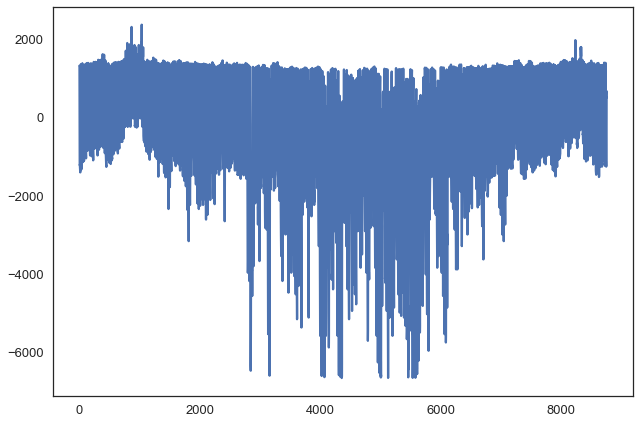

In [137]:
plt.plot(DH_matrix[2][4])

In [102]:
#get installed capacities in all hubs/nodes for all demands
capacities_matrix = np.zeros(((data.Technologies.shape[2]+1)*data.numberofdemands, data.numberofhubs))
for i in range(data.numberofhubs):
    for j in range(data.Technologies.shape[2]+1):
        for k in range(data.numberofdemands):
            capacities_matrix[j*4+k,i] = model.Capacities[i+1,j+1,k+1].value   #change 4 to number of demands
            
Capacities = pd.DataFrame(capacities_matrix)  
Capacities = Capacities.replace(to_replace='NaN', value=0)
Capacities.columns = range(1,len(Capacities.columns)+1)
Capacities

AttributeError: 'module' object has no attribute 'Technologies'

In [21]:
#operation for all timesteps for all nodes/hubs

operation_dict={}
for i in range(data.numberofhubs):
    matrix=np.zeros((data.DemandData.shape[1],data.Technologies.shape[2]+1))
    for j in range(data.DemandData.shape[1]):
        for k in range(data.Technologies.shape[2]+1):
            matrix[j,k] = model.P[i+1,j+1,k+1].value
    operation_dict[i]=matrix
operation = pd.Panel(operation_dict)
for n in range(1,len(operation.items)):
    operation[n].columns = ["Electricity", "WP", "HK", "KM", "SeeCool", "Cooling", "SeeWarm"] #change column names to tech names
    
operation_total = operation.sum(axis = 0)
operation_total.columns = ["Electricity", "WP", "HK", "KM", "SeeCool", "Cooling", "SeeWarm"] #change column names to tech names
operation_total[operation_total<0]=0
operation_total["SeeWarm"] = -1* operation_total["SeeWarm"] 

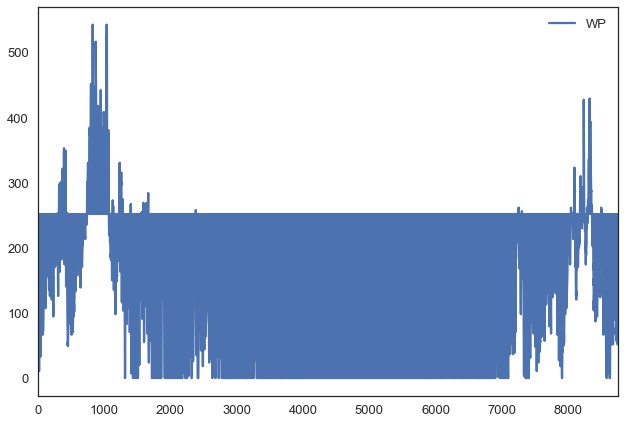

In [50]:
operation[16].plot.line(y=["WP"])

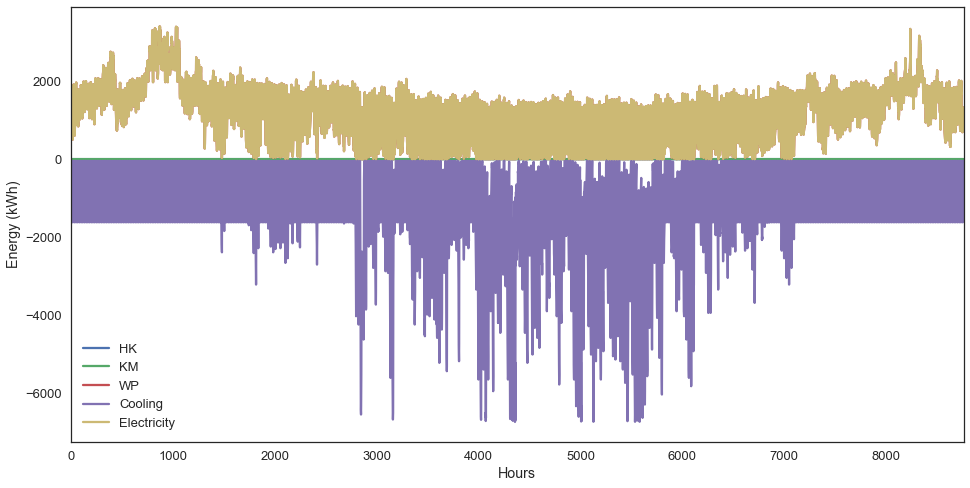

In [246]:
#plot operation

sns.set_context("talk")
sns.set_style('white')


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

dummy=operation_total.copy()
#dummy["Cooling"] = -1* dummy["Cooling"]
dummy.plot.line(y=[ "HK","KM",  "WP",  "Cooling","Electricity"], ax=ax)

plt.ylabel('Energy (kWh)') #, **{'fontsize': 14}
plt.xlabel('Hours')
#plt.xticks(rotation = 90)
#ax.set_xticklabels(list(timedamage["FlightDate"][::5]))

plt.axis('tight')
#print ax.get_xlim()
#plt.ylim(0,3500)
plt.xlim(-1,8761)

plt.show()

path=r'C:\All.png'#path to png
fig.savefig(path,bbox_inches='tight',dpi=500) #save the fig

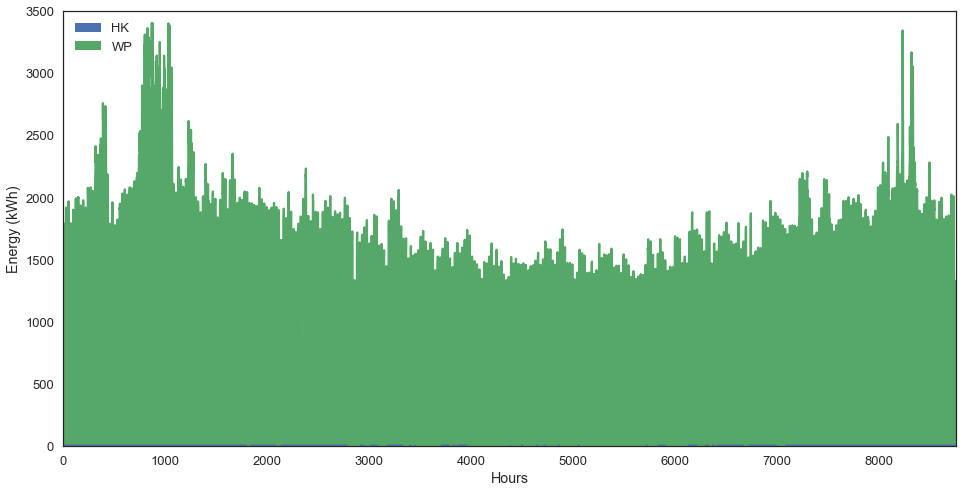

In [233]:
#plot heating
sns.set_context("talk")
sns.set_style('white')


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)


operation_total.plot.area(y=["HK","WP"], ax=ax)

plt.ylabel('Energy (kWh)') #, **{'fontsize': 14}
plt.xlabel('Hours')

plt.axis('tight')
#print ax.get_xlim()
plt.ylim(0,3500)
plt.xlim(-1,8761)

plt.show()

path=r'C:\Heat.png'#path to png
fig.savefig(path,bbox_inches='tight',dpi=500) #save the fig

In [188]:
df = operation_total[["HK","WP"]]
df.index = range(1,8761)
#df.columns=[str(i+1)+'-'+str(j+1)]
df.to_excel('Heat_abdeckung.xlsx',header=True,index=True) #, sep=',', float_format="%6.0f"

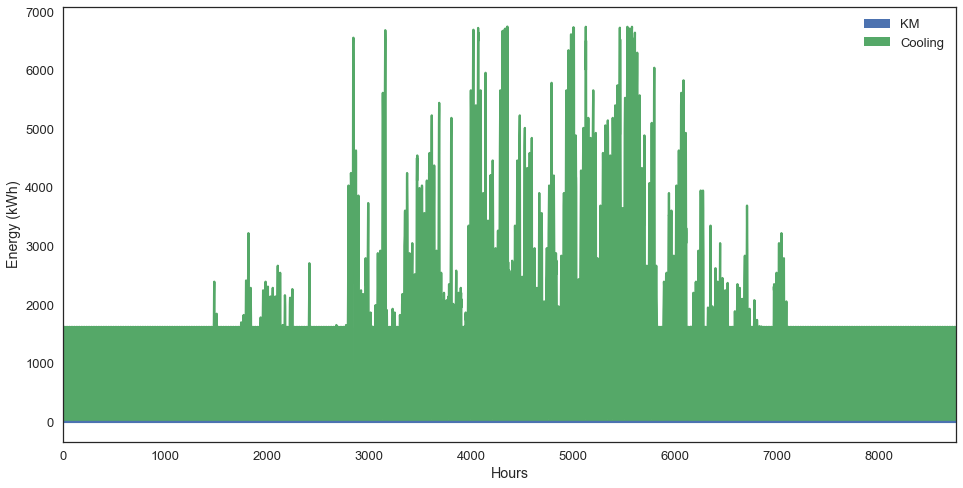

In [231]:
sns.set_context("talk")
sns.set_style('white')


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

operation_total.plot.area(y=["KM","Cooling"], ax=ax)

plt.ylabel('Energy (kWh)') #, **{'fontsize': 14}
plt.xlabel('Hours')
plt.axis('tight')

plt.xlim(-1,8761)

plt.show()

path=r'C:\Cool.png'#path to png
fig.savefig(path,bbox_inches='tight',dpi=500) #save the fig

In [189]:
df = operation_total[["KM","Cooling"]]
df.index = range(1,8761)
df.to_excel('Cool_abdeckung.xlsx',header=True,index=True) #, sep=',', float_format="%6.0f"

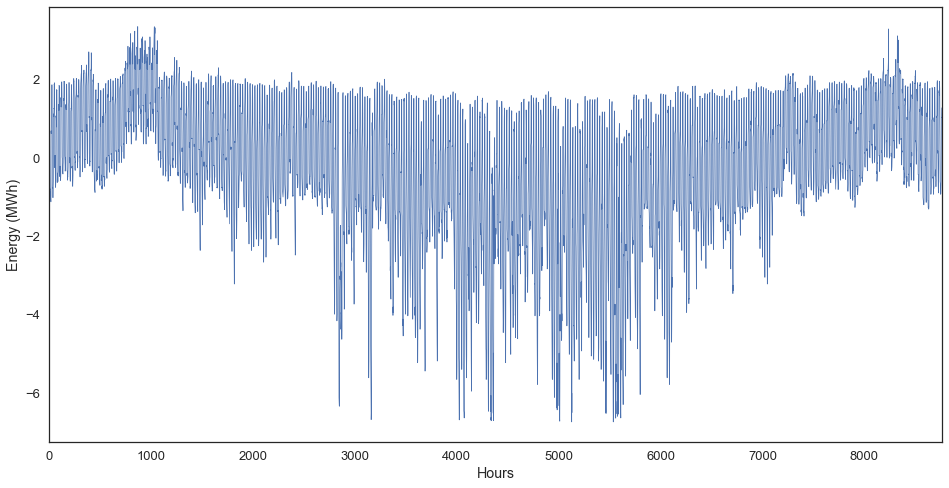

In [222]:
sns.set_context("talk")
sns.set_style('white')


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

dummy = -1*(operation_total["SeeCool"]+operation_total["SeeWarm"])/1000
dummy.plot(ax=ax, **{'linewidth':0.7})

plt.ylabel('Energy (MWh)') #, **{'fontsize': 14}
plt.xlabel('Hours')


plt.axis('tight')

plt.xlim(-1,8761)

plt.show()

path=r'C:\See.png'#path to png
fig.savefig(path,bbox_inches='tight',dpi=500) #save the fig

In [195]:
dummy =pd.DataFrame(-1*(operation_total["SeeCool"]+operation_total["SeeWarm"]))
dummy.index = list(range(1,8761))
dummy.to_excel('See_Energiebezug.xlsx',header=True,index=True)

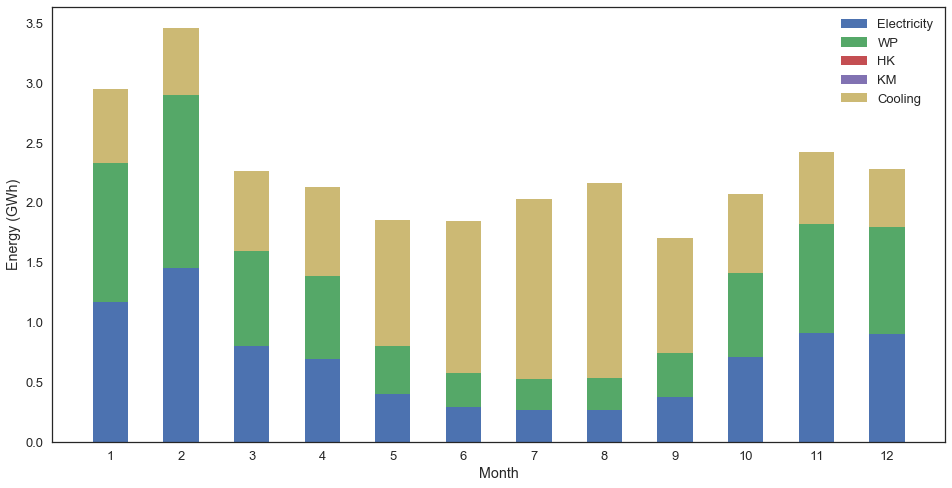

In [219]:
sns.set_context("talk")
sns.set_style('white')


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

months=[31,28,31,30,31,30,31,31,30,31,30,31]
month_op=[]
for n,val in enumerate(months):
    month_op.append(operation_total.iloc[n*val*24:(n+1)*val*24,:].sum()/1000000)

df=pd.DataFrame(month_op)
df.index=list(range(1,13))  
df.plot.bar(stacked=True, y=["Electricity", "WP", "HK", "KM", "Cooling"], ax=ax)

plt.xlabel('Month') #, **{'fontsize': 14}
plt.ylabel('Energy (GWh)')
plt.xticks(rotation = 0)


plt.axis('tight')

path=r'C:\Month.png'#path to png
fig.savefig(path,bbox_inches='tight',dpi=500) #save the fig

In [223]:
months=[31,28,31,30,31,30,31,31,30,31,30,31]
month_op=[]
for n,val in enumerate(months):
    month_op.append(operation_total.iloc[n*val*24:(n+1)*val*24,:].sum()/1000000)

df=pd.DataFrame(month_op)
df.index=list(range(1,13)) 
df.to_excel('Monate_Profilen.xlsx',header=True,index=True)

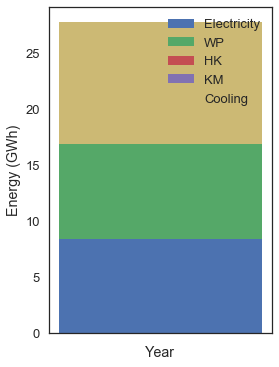

In [228]:
sns.set_context("talk")
sns.set_style('white')


fig = plt.figure(figsize=(4,6))
ax = fig.add_subplot(111)



df=pd.DataFrame(operation_total.sum()/1000000)
df=df.transpose()
df.plot.bar(stacked=True, y=["Electricity", "WP", "HK", "KM", "Cooling"], ax=ax)

plt.xlabel('Year') #, **{'fontsize': 14}
plt.ylabel('Energy (GWh)')
plt.xticks(rotation = 0)
ax.set_xticklabels([])

plt.axis('tight')

path=r'C:\Year.png'#path to png
fig.savefig(path,bbox_inches='tight',dpi=500) #save the fig

In [229]:
df=pd.DataFrame(operation_total.sum()/1000000)
df=df.transpose()
df.to_excel('Year.xlsx',header=True,index=True)